In [1]:
# 测试 CSVSupToneDataset 是否正确筛选并加载数据

import pandas as pd
import torchaudio
from torch.utils.data import DataLoader
import torch.nn.functional as F
import random
from datasets import CSVSupToneDataset

# 假设你已经将上面的 CSVSupToneDataset 放在同一个文件里，这里直接定义测试函数

def test_csv_dataset(csv_path, batch_size=4):

    # 1. 读 CSV 并打印总行数与筛选后行数
    df_all = pd.read_csv(csv_path)
    print(f"原始 CSV 行数: {len(df_all)}")
    df_filtered = df_all[df_all[['gain','treble','mid','bass']].notnull().all(axis=1)]
    print(f"筛选后行数: {len(df_filtered)} (仅含 gain/treble/mid/bass)")

    # 2. 构造 Dataset & DataLoader
    ds = CSVSupToneDataset(csv_path, clip_sec=1.0)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

    # 3. 取一个 batch，打印形状与标签分布
    c1, c2, labels = next(iter(loader))
    print("c1 batch shape:", c1.shape)   # 应为 [B,1,clip_len]
    print("c2 batch shape:", c2.shape)
    print("labels:", labels)

    # 4. 验证参数列全部存在，且均为浮点
    sample_row = df_filtered.iloc[0]
    print("Example params:", 
          "gain=", sample_row['gain'], 
          "treble=", sample_row['treble'], 
          "mid=", sample_row['mid'], 
          "bass=", sample_row['bass'])

if __name__ == "__main__":
    csv_path = "all_data.csv"  # 改成你的文件名
    test_csv_dataset(csv_path)


/tmp/ipykernel_1314/200404886.py:15: DtypeWarning: Columns (6,7,17,18,19,20,21,22,23,24,25,27,29,30,32,36,37,38,41,43,61,62,63,64,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(csv_path)
/root/autodl-tmp/code/datasets.py:17: DtypeWarning: Columns (6,7,17,18,19,20,21,22,23,24,25,27,29,30,32,36,37,38,41,43,61,62,63,64,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


原始 CSV 行数: 18959
筛选后行数: 9108 (仅含 gain/treble/mid/bass)
c1 batch shape: torch.Size([4, 1, 44100])
c2 batch shape: torch.Size([4, 1, 44100])
labels: tensor([1, 3, 3, 3])
Example params: gain= 6.0 treble= 6.0 mid= 5.0 bass= 3.0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from datasets import CSVSupToneDataset
from toneEncoder import ToneEncoder
from losses import SupConLoss

# … ToneEncoder, nt_xent_loss, CSVSupToneDataset 等保持不变 …

def make_dataloaders(train_csv, val_csv, batch_size=32, num_workers=(4,2)):
    """
    构建训练和验证 DataLoader
    返回: train_loader, val_loader
    """
    train_ds = CSVSupToneDataset(train_csv)
    val_ds   = CSVSupToneDataset(val_csv)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers[0]
    )
    val_loader   = DataLoader(
        val_ds,   batch_size=batch_size,
        shuffle=False, drop_last=False, num_workers=num_workers[1]
    )
    return train_loader, val_loader, train_ds, val_ds

# ------------------------------------------------------------------
# 2) 训练函数（改为 SupConLoss）
# ------------------------------------------------------------------
def train_supcon(
    model, train_loader, val_loader,
    epochs=20, lr=3e-4, device='cuda'
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
    )

    # SupCon loss：
    criterion = SupConLoss(temperature=0.07).to(device)

    # TensorBoard
    logdir = "runs/supcon_" + datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(logdir)

    best_val = float('inf')
    for epoch in range(1, epochs + 1):
        # ——— Train ———
        model.train()
        train_loss = 0.0
        for c1, c2, label in train_loader:
            c1, c2, label = c1.to(device), c2.to(device), label.to(device)

            z1 = model(c1)               # [B, D]
            z2 = model(c2)               # [B, D]

            # 拼成 SupCon 需要的形状 [B, n_views, D]
            feats = torch.stack([z1, z2], dim=1)   # [B, 2, D]

            loss = criterion(feats, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # ——— Validation ———
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for c1, c2, label in val_loader:
                c1, c2, label = c1.to(device), c2.to(device), label.to(device)
                z1 = model(c1)
                z2 = model(c2)
                feats = torch.stack([z1, z2], dim=1)
                val_loss += criterion(feats, label).item()
        val_loss /= len(val_loader)

        # LR 调度
        scheduler.step(val_loss)

        # 日志和保存
        lr_now = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | lr={lr_now:.1e} | train={train_loss:.4f} | val={val_loss:.4f}")
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val",   val_loss,   epoch)
        writer.add_scalar("LR",         lr_now,     epoch)

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "best_supcon_tone_encoder.pth")

    writer.close()
    return model

# ------------------------------------------------------------------
# 3) 主程序
# ------------------------------------------------------------------
if __name__ == "__main__":
    train_loader, val_loader, *_ = make_dataloaders(
        "train.csv", "val.csv",
        batch_size=32, num_workers=(4, 2)
    )

    tone_encoder = ToneEncoder()
    trained = train_supcon(
        tone_encoder, train_loader, val_loader,
        epochs=100, lr=3e-4,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )


KeyboardInterrupt: 

In [3]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

# 假设你已经定义好 ToneEncoder 和 CSVSupToneDataset
# tone_encoder_ckpt = "best_simclr_tone_encoder.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) 加载已训练好的 encoder
tone_encoder = ToneEncoder(projection_dim=128).to(device)
tone_encoder.load_state_dict(torch.load("best_supcon_tone_encoder.pth", map_location=device))
tone_encoder.eval()

# 2) 构建 Dataset & DataLoader，只取 c1
dataset = CSVSupToneDataset("val.csv", sample_rate=44100, clip_sec=1.0)
loader  = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

embeddings = []
labels     = []

with torch.no_grad():
    for c1, c2, label in tqdm(loader, desc="Extract embeddings"):
        # c1: [B,1,T]
        c1 = c1.to(device)
        z  = tone_encoder(c1)      # [B, 128]
        embeddings.append(z.cpu().numpy())
        labels.extend(label.numpy().tolist())

# 3) 拼接结果
embs = np.vstack(embeddings)      # shape [N,128]
df = pd.DataFrame(embs, columns=[f"dim{i}" for i in range(128)])
df["label_idx"] = labels

# 4) 导出
df.to_csv("tone_embeddings_supcon.csv", index=False)
print("Saved tone_embeddings_supcon.csv")


Extract embeddings: 100%|██████████| 29/29 [00:02<00:00, 12.28it/s]


Saved tone_embeddings_supcon.csv


/root/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


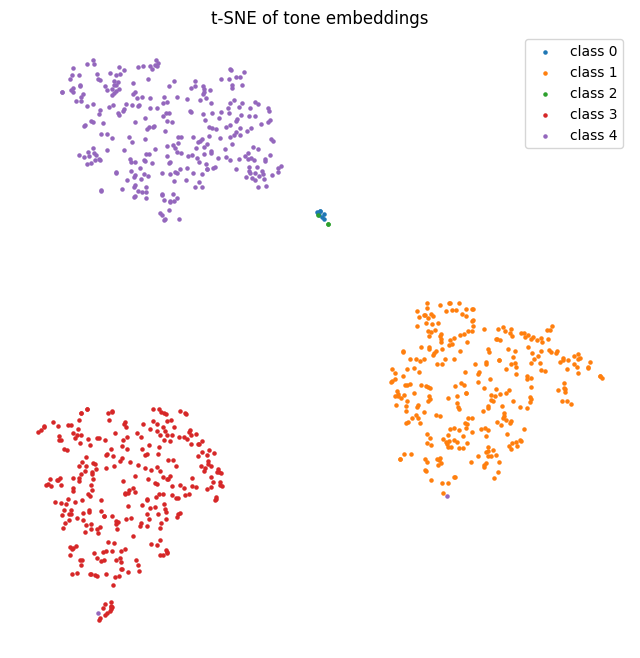

In [4]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

df = pd.read_csv("tone_embeddings_supcon.csv")
X  = df[[f"dim{i}" for i in range(128)]].values
y  = df["label_idx"].values

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
Z    = tsne.fit_transform(X)

plt.figure(figsize=(8,8))
for lbl in np.unique(y):
    idx = y==lbl
    plt.scatter(Z[idx,0], Z[idx,1], label=f"class {lbl}", s=5)
plt.legend(bbox_to_anchor=(1,1))
plt.title("t-SNE of tone embeddings")
plt.axis("off")
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio

def loudness_match(a, b, eps=1e-8):
    # a, b : [B, 1, T] float
    rms_a = (a**2).mean(dim=-1, keepdim=True).sqrt()   # [B,1,1]
    rms_b = (b**2).mean(dim=-1, keepdim=True).sqrt()
    b_adj = b * (rms_a / (rms_b + eps))
    return b_adj.clamp(-1, 1)

# -----------------------------------
# 1) –12 dBFS 峰值归一化
# -----------------------------------
def peak_normalize(wav, target_dbfs=-12.0):
    # wav: Tensor [1, T], 假定振幅在 [-1,1]
    peak = wav.abs().max()
    if peak > 0:
        # target linear = 10^(dB/20)
        tgt = 10.0 ** (target_dbfs / 20.0)
        wav = wav * (tgt / peak)
    return wav

# -----------------------------------
# 2) Dataset：干/湿 对与 reference
# -----------------------------------


# -----------------------------------
# 3) FiLM-GCN Generator
# -----------------------------------
class FiLMGCNBlock(nn.Module):
    def __init__(self, C, dilation):
        super().__init__()
        self.filt = nn.Conv1d(C, C, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.gate = nn.Conv1d(C, C, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.to_gamma = nn.Linear(128, C, bias=True)
        self.to_beta  = nn.Linear(128, C, bias=True)
        self.res_conv = nn.Conv1d(C, C, kernel_size=1)
    def forward(self, x, φ):
        # 打印一下进入和离开这个 block 的形状
        # print("  FiLM in:", x.shape, φ.shape)
        h = torch.tanh(self.filt(x)) * torch.sigmoid(self.gate(x))
        γ = self.to_gamma(φ).unsqueeze(-1)
        β = self.to_beta(φ).unsqueeze(-1)
        h = γ * h + β
        out = self.res_conv(h) + x[..., :h.size(-1)]
        # print("  FiLM out:", out.shape)
        return out

class GeneratorFiLMGCN(nn.Module):
    def __init__(self, in_ch=1, C=32, L=16):
        super().__init__()
        self.init_conv = nn.Conv1d(in_ch, C, kernel_size=1)
        self.blocks = nn.ModuleList([
            FiLMGCNBlock(C, dilation=2**i) for i in range(L)
        ])
        self.final_conv = nn.Conv1d(C*L, in_ch, kernel_size=1)
    def forward(self, x, φ):
        h = self.init_conv(x)
        # print("after init_conv:", h.shape)  # 应该是 [B, C, T]
        outs = []
        for blk in self.blocks:
            # print("  block input h:", h.shape, "φ:", φ.shape)
            h = blk(h, φ)
            outs.append(h)
        cat = torch.cat(outs, dim=1)  # [B,16*12,T]
        return self.final_conv(cat)

# # -----------------------------------
# # 4) Complex-valued STFT Loss
# # -----------------------------------
# class SpectralLoss(nn.Module):
#     def __init__(self, n_fft=2048, hop_length=512):
#         super().__init__()
#         self.n_fft = n_fft
#         self.hop   = hop_length
#     def forward(self, y_hat, y):
#         # [B,1,T] → complex STFT
#         S1 = torch.stft(y_hat.squeeze(1), self.n_fft, self.hop,
#                         return_complex=True)
#         S2 = torch.stft(y      .squeeze(1), self.n_fft, self.hop,
#                         return_complex=True)
#         return F.mse_loss(S1.real, S2.real) + F.mse_loss(S1.imag, S2.imag)

class MRSTFTLoss(nn.Module):
    def __init__(self, ffts=(256, 512, 1024, 2048), hop_ratio=0.25, w_log=True):
        super().__init__()
        self.ffts = ffts
        self.hops = [int(n * hop_ratio) for n in ffts]
        self.w_log = w_log        # True=log1p, False=linear

    def stft_mag(self, x, n_fft, hop):
        win = torch.hann_window(n_fft, device=x.device)
        S = torch.stft(x.squeeze(1), n_fft, hop, window=win, return_complex=True)
        mag = S.abs()
        return torch.log1p(mag) if self.w_log else mag

    def forward(self, y_hat, y):
        loss = 0.
        for n, h in zip(self.ffts, self.hops):
            M1 = self.stft_mag(y_hat, n, h)
            M2 = self.stft_mag(y,     n, h)
            loss += F.l1_loss(M1, M2)
        # 叠加少量时域 L1
        loss += 0.05 * F.l1_loss(y_hat, y)
        return loss / len(self.ffts)

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio

from toneEncoder import ToneEncoder
from datasets import AmpPairDataset
from generator import FiLMGCNBlock, GeneratorFiLMGCN
from losses import ComplexSpectralLoss, SpectralLoss, MRSTFTLoss
from helper import peak_normalize, loudness_match

def train_generator(train_df, val_df, tone_ckpt,
                    epochs=50, bs=12, lr=1e-4, device='cuda'):
    # load tone encoder E
    toneE = ToneEncoder()    # 请换成你自己的 SimCLR+proj 512→128 实现
    toneE.load_state_dict(torch.load(tone_ckpt))
    toneE.to(device)

    # dataset & loader
    ds_tr = AmpPairDataset(train_df, clip_sec=3.5, device=device);  dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  num_workers=0)
    ds_va = AmpPairDataset(val_df, clip_sec=3.5, device=device);  dl_va = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=0)

    G    = GeneratorFiLMGCN().to(device)
    loss_fn = MRSTFTLoss(ffts=[1024]).to(device)
    # loss_fn = ComplexSpectralLoss(n_fft=2048, hop_length=512, alpha_rms=1).to(device)
    # loss_fn = SpectralLoss().to(device)
    opt     = torch.optim.Adam(G.parameters(), lr=lr)
    # 在验证损失 plateau 后，lr = lr * factor
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, min_lr=1e-7)
    
    best_val = float('inf')
    for ep in range(1, epochs+1):
        G.train();  t_loss = 0
        toneE.eval()
        for x,y,z,_ in dl_tr:
            x,y,z = x.to(device), y.to(device), z.to(device)
            with torch.no_grad():
                φ = toneE(z)
            φ = φ.squeeze(0)
            φ = φ.to(device)
            ŷ = G(x,φ)
            loss = loss_fn(ŷ, y)
            opt.zero_grad(); loss.backward(); opt.step()
            t_loss += loss.item()
        t_loss /= len(dl_tr)

        G.eval(); v_loss = 0
        with torch.no_grad():
            for x,y,z,_ in dl_va:
                x,y,z = x.to(device), y.to(device), z.to(device)
                with torch.no_grad():
                    φ = toneE(z)
                φ = φ.squeeze(0)
                φ = φ.to(device)
                v_loss += loss_fn(G(x,φ), y).item()
        v_loss /= len(dl_va)
        scheduler.step(v_loss)
        current_lr = opt.param_groups[0]['lr']
        print(f"Epoch {ep:2d} | lr={current_lr:.1e}  train={t_loss:.4f}  val={v_loss:.4f}")
        if v_loss < best_val:
            best_val = v_loss
            torch.save(G.state_dict(), "Best_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth")

    return G

# -----------------------------
# 6) 开始训练示例
# -----------------------------
if __name__=="__main__":
    import pandas as pd
    # train_pairs.csv/val_pairs.csv: 包含 direct_input/output/tone_ref_path
    df_tr = pd.read_csv("train.csv")
    df_va = pd.read_csv("val.csv")
    G = train_generator(df_tr, df_va, epochs=80, bs=8, tone_ckpt="best_supcon_tone_encoder.pth")
    torch.save(G.state_dict(), "MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth")

Epoch  1 | lr=1.0e-04  train=0.0646  val=0.0629
Epoch  2 | lr=1.0e-04  train=0.0619  val=0.0602
Epoch  3 | lr=1.0e-04  train=0.0604  val=0.0611
Epoch  4 | lr=1.0e-04  train=0.0606  val=0.0599
Epoch  5 | lr=1.0e-04  train=0.0601  val=0.0601
Epoch  6 | lr=1.0e-04  train=0.0600  val=0.0593
Epoch  7 | lr=1.0e-04  train=0.0597  val=0.0593
Epoch  8 | lr=1.0e-04  train=0.0595  val=0.0598
Epoch  9 | lr=1.0e-04  train=0.0595  val=0.0589
Epoch 10 | lr=1.0e-04  train=0.0592  val=0.0586
Epoch 11 | lr=1.0e-04  train=0.0590  val=0.0583
Epoch 12 | lr=1.0e-04  train=0.0587  val=0.0586
Epoch 13 | lr=1.0e-04  train=0.0581  val=0.0576
Epoch 14 | lr=1.0e-04  train=0.0578  val=0.0573
Epoch 15 | lr=1.0e-04  train=0.0577  val=0.0576
Epoch 16 | lr=1.0e-04  train=0.0577  val=0.0572
Epoch 17 | lr=1.0e-04  train=0.0576  val=0.0573
Epoch 18 | lr=1.0e-04  train=0.0575  val=0.0573
Epoch 19 | lr=1.0e-04  train=0.0572  val=0.0572
Epoch 20 | lr=1.0e-04  train=0.0571  val=0.0566
Epoch 21 | lr=1.0e-04  train=0.0568  val

In [2]:
# 补训练用代码

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio

from toneEncoder import ToneEncoder
from datasets import AmpPairDataset
from generator import FiLMGCNBlock, GeneratorFiLMGCN
from losses import MRSTFTLoss
from helper import peak_normalize, loudness_match

def train_generator_more(train_df, val_df, tone_ckpt, generator_ckpt,
                    epochs=50, bs=12, lr=1e-4, device='cuda'):
    # load tone encoder E
    toneE = ToneEncoder()    # 请换成你自己的 SimCLR+proj 512→128 实现
    toneE.load_state_dict(torch.load(tone_ckpt))
    toneE.to(device)

    # dataset & loader
    ds_tr = AmpPairDataset(train_df, clip_sec=3.5, device=device);  dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  num_workers=0)
    ds_va = AmpPairDataset(val_df,   clip_sec=3.5, device=device);  dl_va = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=0)

    G    = GeneratorFiLMGCN()
    G.load_state_dict(torch.load(generator_ckpt))
    G.to(device)
    loss_fn = MRSTFTLoss(ffts=[1024]).to(device)
    opt     = torch.optim.Adam(G.parameters(), lr=lr)
    # 在验证损失 plateau 后，lr = lr * factor
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, min_lr=1e-7)
    best_val = 0
    for ep in range(1, epochs+1):
        G.train();  t_loss = 0
        toneE.eval()
        for x,y,z,_ in dl_tr:
            x,y,z = x.to(device), y.to(device), z.to(device)
            with torch.no_grad():
                φ = toneE(z)
            φ = φ.squeeze(0)
            φ = φ.to(device)
            ŷ = G(x,φ)
            loss = loss_fn(ŷ, y)
            opt.zero_grad(); loss.backward(); opt.step()
            t_loss += loss.item()
        t_loss /= len(dl_tr)

        G.eval(); v_loss = 0
        with torch.no_grad():
            for x,y,z,_ in dl_va:
                x,y,z = x.to(device), y.to(device), z.to(device)
                with torch.no_grad():
                    φ = toneE(z)
                φ = φ.squeeze(0)
                φ = φ.to(device)
                v_loss += loss_fn(G(x,φ), y).item()
        v_loss /= len(dl_va)
        scheduler.step(v_loss)
        current_lr = opt.param_groups[0]['lr']
        print(f"Epoch {ep:2d} | lr={current_lr:.1e}  train={t_loss:.4f}  val={v_loss:.4f}")
        if v_loss < best_val:
            best_val = v_loss
            torch.save(G.state_dict(), "Best_MRSTFT_1024nfft_0.8_0.2_film_gcn_generator_clip_3.5_bs_8.pth")

    return G

# -----------------------------
# 6) 开始训练示例
# -----------------------------
if __name__=="__main__":
    import pandas as pd
    # train_pairs.csv/val_pairs.csv: 包含 direct_input/output/tone_ref_path
    df_tr = pd.read_csv("train.csv")
    df_va = pd.read_csv("val.csv")
    G = train_generator_more(df_tr, df_va, epochs=54, bs=8, lr=5.0e-05, tone_ckpt="best_supcon_tone_encoder.pth", generator_ckpt="Best_MRSTFT_1024nfft_0.8_0.2_film_gcn_generator_clip_3.5_bs_8.pth")
    torch.save(G.state_dict(), "MRSTFT_1024nfft_0.8_0.2_film_gcn_generator_clip_3.5_bs_8.pth")

Epoch  1 | lr=5.0e-05  train=0.0567  val=0.0566
Epoch  2 | lr=5.0e-05  train=0.0567  val=0.0562
Epoch  3 | lr=5.0e-05  train=0.0565  val=0.0565
Epoch  4 | lr=5.0e-05  train=0.0565  val=0.0562
Epoch  5 | lr=5.0e-05  train=0.0564  val=0.0561
Epoch  6 | lr=5.0e-05  train=0.0564  val=0.0563
Epoch  7 | lr=5.0e-05  train=0.0562  val=0.0562
Epoch  8 | lr=5.0e-05  train=0.0561  val=0.0561
Epoch  9 | lr=5.0e-05  train=0.0561  val=0.0558
Epoch 10 | lr=5.0e-05  train=0.0560  val=0.0554
Epoch 11 | lr=5.0e-05  train=0.0561  val=0.0555
Epoch 12 | lr=5.0e-05  train=0.0559  val=0.0557
Epoch 13 | lr=5.0e-05  train=0.0558  val=0.0557
Epoch 14 | lr=2.5e-05  train=0.0559  val=0.0555
Epoch 15 | lr=2.5e-05  train=0.0555  val=0.0555
Epoch 16 | lr=2.5e-05  train=0.0553  val=0.0551
Epoch 17 | lr=2.5e-05  train=0.0556  val=0.0555
Epoch 18 | lr=2.5e-05  train=0.0554  val=0.0556
Epoch 19 | lr=2.5e-05  train=0.0554  val=0.0552
Epoch 20 | lr=2.5e-05  train=0.0553  val=0.0550
Epoch 21 | lr=2.5e-05  train=0.0553  val

In [ ]:
# In your notebook cell:

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd

from toneEncoder       import ToneEncoder
from generator         import GeneratorFiLMGCN
from losses            import MRSTFTLoss
from datasets          import AmpPairDataset    # 你原先的 one-shot dataset
from helper            import loudness_match

def train_generator_multisample(
    train_df, val_df, tone_ckpt,
    epochs=50, bs=4,
    clip_sec=1.0,     # 多采样时每段秒数
    samples_per_clip=3,  # 随机切几段
    lr=1e-4, device='cuda'
):
    device = torch.device(device)

    # 1. tone encoder
    toneE = ToneEncoder().to(device).eval()
    toneE.load_state_dict(torch.load(tone_ckpt, map_location=device))
    for p in toneE.parameters(): p.requires_grad = False

    # 2. Dataset & DataLoader
    ds_tr = AmpPairDataset(train_df, toneE, device=device)
    ds_va = AmpPairDataset(val_df,   toneE, device=device)
    dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=0)

    # 3. Generator & Loss & Optimizer
    G      = GeneratorFiLMGCN().to(device)
    loss_fn= MRSTFTLoss().to(device)
    opt    = torch.optim.Adam(G.parameters(), lr=lr)
    sched  = torch.optim.lr_scheduler.ReduceLROnPlateau(
                 opt, mode='min', factor=0.5, patience=3, min_lr=1e-7)

    # 4. multisample_loss: 随机切 K 段
    def multisample_loss(x_full, y_full, φ):
        """
        x_full, y_full: [1, T_full], φ: [D]
        随机切 samples_per_clip 段，每段 clip_sec 秒，pad 到相同长度，
        对每段前向计算 loss_fn，最后返回平均。
        """
        sr     = ds_tr.sr
        clip_L = int(sr * clip_sec)
        L      = x_full.size(-1)

        # 先计算所有可能的 start idx
        max_start = max(L - clip_L, 0)
        # 如果整条比 clip_L 短，就只有一个 segment，从 0 pad 到 clip_L
        if max_start == 0:
            starts = [0] * samples_per_clip
        else:
            # 从 [0..max_start] 中随机采样 samples_per_clip 个 start
            starts = torch.randint(0, max_start + 1, (samples_per_clip,)).tolist()

        seg_losses = []
        for s in starts:
            e = min(L, s + clip_L)
            x_seg = x_full[:, s:e]
            y_seg = y_full[:, s:e]
            # pad
            if x_seg.size(-1) < clip_L:
                pad = clip_L - x_seg.size(-1)
                x_seg = F.pad(x_seg, (0, pad))
                y_seg = F.pad(y_seg, (0, pad))
            # forward
            y_hat = G(x_seg, φ.unsqueeze(0))
            # align back & compute loss
            y_hat = y_hat[:, :, : y_seg.size(-1)]
            seg_losses.append(loss_fn(y_hat, y_seg))

        return torch.stack(seg_losses).mean()

    best_val = float('inf')
    for ep in range(1, epochs+1):
        # ——— Training ———
        G.train()
        total_loss = 0
        for x_full, y_full, φ in dl_tr:
            # x_full, y_full: [B,1,T], φ: [B,D]
            batch_losses = []
            for b in range(x_full.size(0)):
                x_b = x_full[b].to(device)
                y_b = y_full[b].to(device)
                φ_b = φ[b].to(device)
                # loudness match
                y_b = loudness_match(x_b, y_b)
                batch_losses.append(multisample_loss(x_b, y_b, φ_b))
            loss = torch.stack(batch_losses).mean()
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item()
        avg_train = total_loss / len(dl_tr)

        # ——— Validation ———
        G.eval()
        total_val = 0
        with torch.no_grad():
            for x_full, y_full, φ in dl_va:
                val_losses = []
                for b in range(x_full.size(0)):
                    x_b = x_full[b].to(device)
                    y_b = y_full[b].to(device)
                    φ_b = φ[b].to(device)
                    y_b = loudness_match(x_b, y_b)
                    val_losses.append(multisample_loss(x_b, y_b, φ_b))
                total_val += torch.stack(val_losses).mean().item()
        avg_val = total_val / len(dl_va)

        # scheduler & logging
        sched.step(avg_val)
        lr_now = opt.param_groups[0]['lr']
        print(f"Ep{ep:2d} | lr={lr_now:.1e}  train={avg_train:.4f}  val={avg_val:.4f}")

        # save best
        if avg_val < best_val:
            best_val = avg_val
            torch.save(G.state_dict(), "best_generator_multisample.pth")

    return G

# — 在 Notebook 直接跑 —
import pandas as pd

df_tr = pd.read_csv("train.csv")
df_va = pd.read_csv("val.csv")

trained_G = train_generator_multisample(
    train_df=df_tr,
    val_df=df_va,
    tone_ckpt="best_supcon_tone_encoder.pth",
    epochs=200,
    bs=4,                # 批大小
    clip_sec=1,        # 每段长度 1s
    samples_per_clip=3,  # 随机切 3 段
    lr=1e-4,
    device="cuda"
)


/root/autodl-tmp/code/losses.py:144: UserWarning: Using a target size (torch.Size([1, 48000])) that is different to the input size (torch.Size([1, 1, 48000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss += 0.05 * F.l1_loss(y_hat, y)


In [4]:
# 放在 Notebook 单元里，eval 完毕或 OOM 之后都可以执行

import torch, gc

# 1) 删除所有大对象引用
#    确保把 model, encoder, 预测结果, loader, metric 等全都 del 掉
try:
    del gen
except NameError:
    pass
try:
    del enc
except NameError:
    pass
try:
    del y_hat, x, y, phi
except NameError:
    pass
try:
    del DataLoader, ds_tr, ds_va  # 也可以删掉
except NameError:
    pass

# 2) 强制回收 Python 侧的垃圾
gc.collect()

# 3) 清空 CUDA 缓存
torch.cuda.empty_cache()

# 再检查一下
print("After cleanup, CUDA memory allocated:", torch.cuda.memory_allocated()/1024**2, "MiB")
print("After cleanup, CUDA cache  reserved:", torch.cuda.memory_reserved()/1024**2, "MiB")


After cleanup, CUDA memory allocated: 137.37353515625 MiB
After cleanup, CUDA cache  reserved: 162.0 MiB


In [4]:
# Cell: 自动探测最大 batch size
import torch, torchaudio, gc
from datasets import AmpPairDataset
from toneEncoder import ToneEncoder
from generator import GeneratorFiLMGCN

DEVICE = "cuda"
# 随便取两条训练数据用来测试 OOM
sample_df = ds_tr.sample(2).reset_index(drop=True)
enc = ToneEncoder().to(DEVICE).eval()
enc.load_state_dict(torch.load("best_supcon_tone_encoder.pth"))
gen = GeneratorFiLMGCN().to(DEVICE).eval()
gen.load_state_dict(torch.load("film_gcn_generator.pth"))

def can_run_bs(bs):
    try:
        ds = AmpPairDataset(sample_df, enc, device=DEVICE)
        dl = torch.utils.data.DataLoader(ds, batch_size=bs)
        for x,y,phi in dl:
            with torch.no_grad():
                _ = gen(x.to(DEVICE), phi.to(DEVICE))
        return True
    except RuntimeError as e:
        if "out of memory" in str(e):
            torch.cuda.empty_cache()
            return False
        else:
            raise

# 从 1 开始指数增长
bs = 1
while can_run_bs(bs):
    print(f"✅ 可以跑 batch size = {bs}")
    bs *= 2

# 回退到上一轮能跑的那个
max_bs = bs // 2
print(f"\n🔍 探测到最大可用 batch size 约为 {max_bs}，建议你用 {max_bs//2}~{max_bs} 之间保守选一个。\n")


NameError: name 'ds_tr' is not defined

In [1]:
import torch
import torch.nn.functional as F
import torchaudio
import pandas as pd
import time
from pathlib import Path
from tqdm import tqdm

from toneEncoder import ToneEncoder
from generator import GeneratorFiLMGCN
from losses import MRSTFTLoss         # ← 直接用你已有的
from helper import peak_normalize, loudness_match

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SR = 48000

# —— 分段切片工具 —— 
def chunkify(wav: torch.Tensor, chunk_len: int):
    T = wav.size(-1)
    starts = list(range(0, T, chunk_len))
    out = []
    for s in starts:
        e = min(T, s + chunk_len)
        seg = wav[..., s:e]
        if e - s < chunk_len:
            seg = F.pad(seg, (0, chunk_len - (e - s)))
        out.append((s, e, seg))
    return out

# —— 加载模型 —— 
enc = ToneEncoder().to(DEVICE).eval()
enc.load_state_dict(torch.load("best_supcon_tone_encoder.pth", map_location=DEVICE))
gen = GeneratorFiLMGCN().to(DEVICE).eval()
gen.load_state_dict(torch.load("MRSTFT_1024nfft_1.0_0.05_film_gcn_generator_clip_3.5_bs_8.pth",   map_location=DEVICE))

# —— loss 实例 —— 
loss_fn = MRSTFTLoss().to(DEVICE)

# —— 读取测试列表 —— 
test_df = pd.read_csv("test.csv")  # 列名：di_file, filename

results = []
chunk_sec = 1
chunk_len = SR * chunk_sec

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # 1) 读干信号 x 和参考湿 y
    x, sr1 = torchaudio.load(row["di_file"])
    y, sr2 = torchaudio.load(row["filename"])
    x = x.mean(0, keepdim=True)
    y = y.mean(0, keepdim=True)
    if sr1 != SR: x = torchaudio.functional.resample(x, sr1, SR)
    if sr2 != SR: y = torchaudio.functional.resample(y, sr2, SR)
    x = peak_normalize(x); y = peak_normalize(y)
    x = loudness_match(x, y)

    x = x.to(DEVICE); y = y.to(DEVICE)

    # 2) 计算 tone embedding φ
    with torch.no_grad():
        φ = enc(y).squeeze(0)  # [128]

    # 3) 分段推理拼回 y_hat
    y_hat = torch.zeros_like(x)
    t0 = time.time()
    for s, e, xi in chunkify(x, chunk_len):
        xi = xi.to(DEVICE)
        with torch.no_grad():
            yi = gen(xi, φ.unsqueeze(0)).clamp(-1,1)
        yi = yi[..., : (e - s)]
        y_hat[..., s:e] = yi
        del xi, yi
        torch.cuda.empty_cache()
    rtf = (time.time() - t0) / (x.size(-1) / SR)

    # 4) 计算 MRSTFTLoss
    mr = loss_fn(y_hat, y).item()

    results.append({
        "di_file": row["di_file"],
        "amp":     row["model"],
        "MRSTFT":  round(mr,4),
        "RTF":     round(rtf,4),
    })

# —— 汇总 —— 
res_df = pd.DataFrame(results)
res_df.to_csv("eval_results.csv", index=False)
# 读取 eval_results.csv
import pandas as pd
res_df = pd.read_csv("eval_results.csv")

# 只选数值列
num_cols = ["MRSTFT", "RTF"]
per_amp = res_df.groupby("amp")[num_cols].mean().round(4)

print("=== per-amp mean ===")
print(per_amp)

print("\n=== overall ===")
print(res_df[num_cols].mean().round(4))


FileNotFoundError: [Errno 2] No such file or directory: 'MRSTFT_1024nfft_1.0_0.05_film_gcn_generator_clip_3.5_bs_8.pth'

In [11]:
import torch
import torchaudio

def rms_db(x: torch.Tensor, eps: float = 1e-9) -> torch.Tensor:
    """
    计算信号的 RMS 能量（dBFS）。
    Args:
        x: Tensor of shape [1, T] 或 [T], 取值范围 [-1,1]
    Returns:
        RMS 能量，以 dBFS 为单位（0 dBFS 对应满量程 RMS=1）
    """
    # 如果是 [1, T]，去掉通道维
    if x.dim() == 2 and x.size(0) == 1:
        x = x.squeeze(0)
    # 计算 RMS
    rms = torch.sqrt(torch.mean(x**2) + eps)
    # 转成 dB：20 * log10(rms / 1.0)
    return 20.0 * torch.log10(rms + eps)

# —— 示例文件路径 —— 
in_path  = "/root/autodl-tmp/unzipped/Fractal - FM3 - USA Lead/USA Lead/001_lorcan_metal_rhythm/001_lorcan_metal_rhythm.wav"
out_path = "/root/autodl-tmp/unzipped/Fractal - FM3 - USA Lead/USA Lead/001_lorcan_metal_rhythm/00000751.wav"

# —— 加载音频 —— 
# torchaudio.load 返回 (waveform, sample_rate)
x_in, sr_in   = torchaudio.load(in_path)
x_out, sr_out = torchaudio.load(out_path)

# （可选）如果采样率不一致，需要重采样：
if sr_in != sr_out:
    x_out = torchaudio.functional.resample(x_out, sr_out, sr_in)
    sr_out = sr_in

# —— 计算 RMS dBFS —— 
db_in  = rms_db(x_in)
db_out = rms_db(x_out)

print(f"Input  RMS:  {db_in.item():.2f} dBFS")
print(f"Output RMS: {db_out.item():.2f} dBFS")
print(f"Gain change: {db_out.item() - db_in.item():+.2f} dB")



Input  RMS:  -20.66 dBFS
Output RMS: -57.18 dBFS
Gain change: -36.52 dB


In [3]:
import torch, torchaudio, numpy as np
from pathlib import Path
from tqdm import tqdm

from toneEncoder       import ToneEncoder
from generator         import GeneratorFiLMGCN
from losses            import MRSTFTLoss
from datasets          import AmpPairDataset    # 你原先的 one-shot dataset
from helper            import loudness_match

# ---------- 用户配置 ----------
di_wav     = "/root/autodl-tmp/unzipped/Fractal - FM3 - USA Lead/USA Lead/001_lorcan_metal_rhythm/001_lorcan_metal_rhythm.wav"          # 纯 DI 输入
ref_wav    = "/root/autodl-tmp/unzipped/Fractal - FM3 - USA Lead/USA Lead/001_lorcan_metal_rhythm/00000751.wav"   # 参考音箱 tone
out_wav    = "/root/autodl-tmp/code/Fractal - FM3 - USA Lead.wav"      # 输出路径
encoder_ckpt = "best_supcon_tone_encoder.pth"
g_ckpt       = "Best_MRSTFT_1024nfft_0.8_0.2_film_gcn_generator_clip_3.5_bs_8.pth"
device       = "cuda" if torch.cuda.is_available() else "cpu"
sr           = 48_000
clip_sec     = 1.0                  # 与训练一致
overlap      = 0.25                 # 25% overlap-add
# --------------------------------

# ========= 1. 加载模型 =========

encoder = ToneEncoder().to(device)
encoder.load_state_dict(torch.load(encoder_ckpt, map_location=device))
encoder.eval()

gen = GeneratorFiLMGCN().to(device)
gen.load_state_dict(torch.load(g_ckpt, map_location=device))
gen.eval()

# ========= 2. 实用函数 =========
def to_mono(wav):               # [C,T] → [1,T]
    return wav.mean(0, keepdim=True)

def peak_norm(x, tgt_db=-12):
    peak = x.abs().max()
    if peak>0:
        x = x * (10**(tgt_db/20) / peak)
    return x

def frame_signal(x, frame_len, hop):
    # x:[1,T] → [N,1,L]
    T = x.size(1)
    idx = torch.arange(0, T-frame_len+1, hop)
    frames = torch.stack([x[:, i:i+frame_len] for i in idx])
    return frames, idx

def overlap_add(frames, idx, T, hop):
    y = torch.zeros(1, T, device=frames.device)
    win = torch.hann_window(frames.size(-1), device=frames.device).unsqueeze(0)
    acc = torch.zeros_like(y)
    for f, start in zip(frames, idx):
        y[:, start:start+f.size(-1)] += f*win
        acc[:, start:start+f.size(-1)] += win
    return (y/acc.clamp_min(1e-6)).cpu()   # → CPU

# ========= 3. 读取音频 =========
di, sr0  = torchaudio.load(di_wav)
ref, sr1 = torchaudio.load(ref_wav)
print(sr0, sr1, sr)
assert sr0==sr1==sr, "采样率不一致"

di  = peak_norm(to_mono(di))
ref = peak_norm(to_mono(ref))

# ========= 4. 计算 tone embedding φ =========
with torch.no_grad():
    φ = encoder(ref.to(device)).squeeze(0)   # [128]

# ========= 5. 分块 + 推理 =========
frame_len = int(sr*clip_sec)
hop_len   = int(frame_len * (1-overlap))
frames, idx = frame_signal(di, frame_len, hop_len)   # [N,1,L]
frames  = frames.to(device)
φ_batch = φ.repeat(frames.size(0), 1)                 # [N,128]

out_frames = []
with torch.no_grad():
    for i in tqdm(range(0, frames.size(0), 8)):
        f = frames[i:i+8]           # 小批量
        p = φ_batch[i:i+8]
        y_hat = gen(f, p)           # [B,1,L]
        out_frames.append(y_hat)
out_frames = torch.cat(out_frames, dim=0)             # [N,1,L]

# ========= 6. Overlap-Add & 写文件 =========
T_total = di.size(1)
wet = overlap_add(out_frames, idx, T_total, hop_len)  # [1,T]
# wet = loudness_match(ref, wet)
torchaudio.save(out_wav, wet, sr)
print(f"✅ Done! 保存到 {out_wav}")


48000 48000 48000


100%|██████████| 2/2 [00:00<00:00, 53.11it/s]

✅ Done! 保存到 /root/autodl-tmp/code/Fractal - FM3 - USA Lead.wav


/root/autodl-tmp/unzipped/Fractal - FM3 - USA IIC++/USA IIC++/005_lorcan_metal_lead/005_lorcan_metal_lead.wav
/root/autodl-tmp/unzipped/Fractal - FM3 - USA IIC++/USA IIC++/005_lorcan_metal_lead/00000609.wav
峰值(dry/wet): 0.17437744140625 0.013824462890625
长度(s): 10.0 10.5


/root/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/torch/functional.py:730: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]


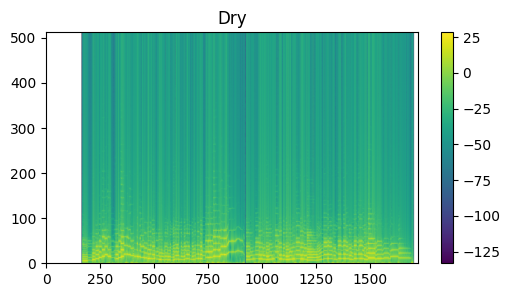

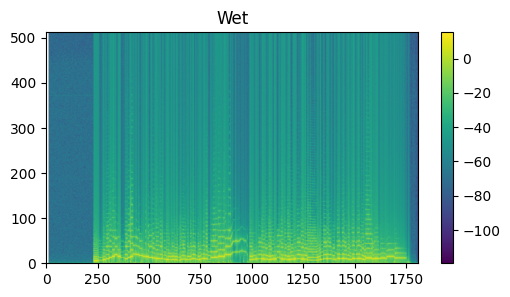

In [4]:
import pandas as pd, torchaudio, torch, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Audio

df = pd.read_csv("train.csv")

# 1) 抽一条样本
row = df.sample(1).iloc[0]
print(row["di_file"])
print(row["filename"])
x, _ = torchaudio.load(row["di_file"])
y, _ = torchaudio.load(row["filename"])

print("峰值(dry/wet):", x.abs().max().item(), y.abs().max().item())
print("长度(s):", x.shape[-1]/44100, y.shape[-1]/44100)

# 画个对比谱
def show_spec(wav, title):
    spec = torch.stft(wav.squeeze(), 1024, hop_length=256, return_complex=True)
    plt.figure(figsize=(6,3)); plt.title(title)
    plt.imshow(20*spec.abs().log10().numpy(), origin="lower", aspect="auto")
    plt.colorbar(); plt.show()

show_spec(x, "Dry")
show_spec(y, "Wet")

# 播放试听（Jupyter 下）
# Audio(x.numpy()[0], rate=44100)
# Audio(y.numpy()[0], rate=44100)


In [12]:
# 假设 toneE 已加载
mm = nn.Sequential(
    nn.Linear(128, 512), nn.ReLU(),
    nn.Linear(512, 513*128)  # 513 频点 * 128 帧（1 s）举例
).cuda()
opt = torch.optim.Adam(mm.parameters(), 1e-3)

for i,(x,y,phi) in enumerate(dl_tr):
    if i==100: break
    x,y,phi = x[:1].cuda(), y[:1].cuda(), phi[:1].cuda()
    target = torch.stft(y.squeeze(1),1024,256,return_complex=True).abs().log10()
    pred   = mm(phi).view_as(target)
    loss = F.mse_loss(pred, target)
    loss.backward(); opt.step(); opt.zero_grad()
    print(i, loss.item())


NameError: name 'dl_tr' is not defined

In [8]:
y,_ = torchaudio.load("ref signal.wav")
y_h,_ = torchaudio.load("Fractal - FM3 - USA Lead.wav")
y = loudness_match(y_h, y)
torchaudio.save("/root/autodl-tmp/code/ref.wav", y, sr)
